In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
from keras_preprocessing.image import ImageDataGenerator

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
train_ds = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical')
test_ds = test_datagen.flow_from_directory(
        'data/test',
        target_size=(150, 150),
        batch_size=64,
        class_mode='categorical')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [6]:
class Involution(keras.layers.Layer):
    def __init__(
        self, channel, group_number, kernel_size, stride, reduction_ratio, name
    ):
        super().__init__(name=name)

        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape

        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride

        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)

        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)

        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)

        # Return the output tensor and the kernel.
        return output, kernel

In [7]:
print("building the involution model...")

inputs = keras.Input(shape=(150, 150, 3))
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_1"
)(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
#112,112,3
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_2"
)(x)
x = keras.layers.ReLU()(x)
#56,56,3
x, _ = Involution(
    channel=3, group_number=1, kernel_size=3, stride=1, reduction_ratio=2, name="inv_3"
)(x)
x = keras.layers.ReLU()(x)
#28,28,3
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation="relu")(x)
outputs = keras.layers.Dense(2)(x)

inv_model = keras.Model(inputs=[inputs], outputs=[outputs], name="inv_model")

# Compile the mode with the necessary loss function and optimizer.
print("compiling the involution model...")
inv_model.compile(
    optimizer="adam",
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

# train the model
print("inv model training...")
inv_hist = inv_model.fit(train_ds, epochs=100, validation_data=test_ds)

building the involution model...
compiling the involution model...
inv model training...
Epoch 1/100
42/42 [==============================] - 27s 429ms/step - loss: 0.6920 - accuracy: 0.5374 - val_loss: 0.6909 - val_accuracy: 0.5455
Epoch 2/100
42/42 [==============================] - 14s 331ms/step - loss: 0.6902 - accuracy: 0.5461 - val_loss: 0.6897 - val_accuracy: 0.5455
Epoch 3/100
42/42 [==============================] - 15s 345ms/step - loss: 0.6894 - accuracy: 0.5461 - val_loss: 0.6893 - val_accuracy: 0.5455
Epoch 4/100
42/42 [==============================] - 17s 393ms/step - loss: 0.6892 - accuracy: 0.5461 - val_loss: 0.6890 - val_accuracy: 0.5455
Epoch 5/100
42/42 [==============================] - 17s 411ms/step - loss: 0.6890 - accuracy: 0.5461 - val_loss: 0.6890 - val_accuracy: 0.5455
Epoch 6/100
42/42 [==============================] - 15s 354ms/step - loss: 0.6890 - accuracy: 0.5461 - val_loss: 0.6890 - val_accuracy: 0.5455
Epoch 7/100
42/42 [============================

Epoch 57/100
42/42 [==============================] - 15s 365ms/step - loss: 0.6891 - accuracy: 0.5461 - val_loss: 0.6890 - val_accuracy: 0.5455
Epoch 58/100
42/42 [==============================] - 19s 441ms/step - loss: 0.6890 - accuracy: 0.5461 - val_loss: 0.6890 - val_accuracy: 0.5455
Epoch 59/100
42/42 [==============================] - 17s 391ms/step - loss: 0.6889 - accuracy: 0.5461 - val_loss: 0.6890 - val_accuracy: 0.5455
Epoch 60/100
42/42 [==============================] - 14s 329ms/step - loss: 0.6889 - accuracy: 0.5461 - val_loss: 0.6890 - val_accuracy: 0.5455
Epoch 61/100
42/42 [==============================] - 14s 341ms/step - loss: 0.6889 - accuracy: 0.5461 - val_loss: 0.6890 - val_accuracy: 0.5455
Epoch 62/100
42/42 [==============================] - 14s 330ms/step - loss: 0.6890 - accuracy: 0.5461 - val_loss: 0.6890 - val_accuracy: 0.5455
Epoch 63/100
42/42 [==============================] - 17s 403ms/step - loss: 0.6889 - accuracy: 0.5461 - val_loss: 0.6890 - val_ac

In [8]:
inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inv_1 (Involution)          ((None, 150, 150, 3),     26        
                              (None, 150, 150, 9, 1,             
                             1))                                 
                                                                 
 re_lu (ReLU)                (None, 150, 150, 3)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 inv_2 (Involution)          ((None, 75, 75, 3),       26        
                              (None, 75, 75, 9, 1, 1)    

building the involution model...
compiling the involution model...
inv model training...


IndexError: tuple index out of range

In [8]:
inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inv_1 (Involution)          ((None, 150, 150, 3),     26        
                              (None, 150, 150, 9, 1,             
                             1))                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 150, 150, 3)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 inv_2 (Involution)          ((None, 75, 75, 3),       26        
                              (None, 75, 75, 9, 1, 1)    

In [9]:
inv_model.summary()

Model: "inv_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 inv_1 (Involution)          ((None, 150, 150, 3),     26        
                              (None, 150, 150, 9, 1,             
                             1))                                 
                                                                 
 re_lu (ReLU)                (None, 150, 150, 3)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 3)        0         
 )                                                               
                                                                 
 inv_2 (Involution)          ((None, 75, 75, 3),       26        
                              (None, 75, 75, 9, 1, 1)    

In [10]:
inv_model(np.zeros((1, 8001, 1)))

ValueError: Input 0 of layer "inv_model" is incompatible with the layer: expected shape=(None, 150, 150, 3), found shape=(1, 8001, 1)

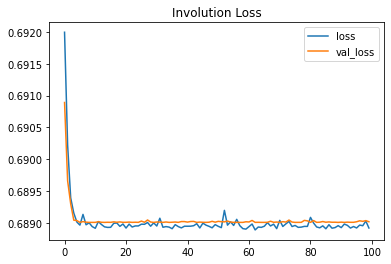

In [11]:
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

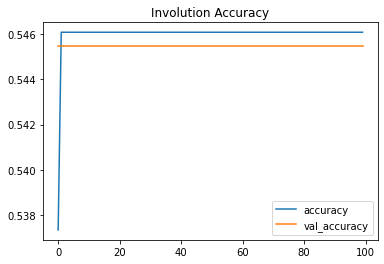

In [12]:
plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

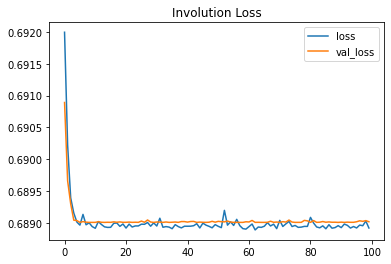

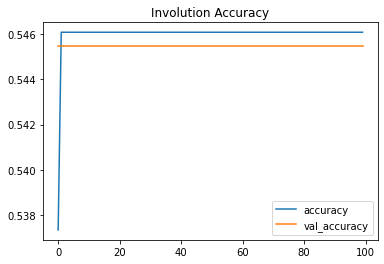

In [13]:
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

In [1]:
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

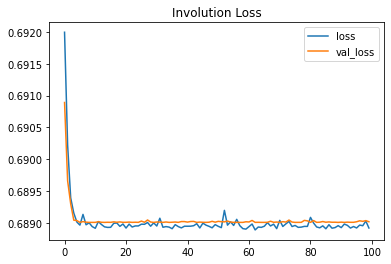

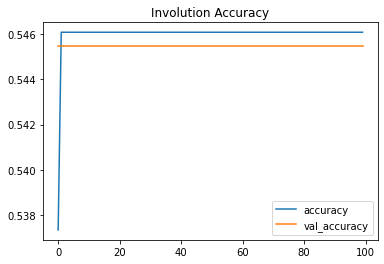

In [14]:
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

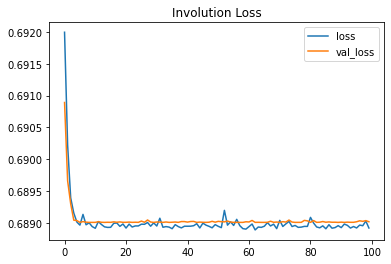

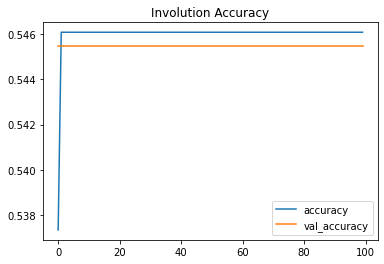

In [17]:
plt.title("Involution Loss")
plt.plot(inv_hist.history["loss"], label="loss")
plt.plot(inv_hist.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.title("Involution Accuracy")
plt.plot(inv_hist.history["accuracy"], label="accuracy")
plt.plot(inv_hist.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

In [18]:
a = [0]*100
l = [0]*100
for i in range(0,100):
    l[i] = inv_hist.history["val_loss"][i] - inv_hist.history["loss"][i]
    a[i] = inv_hist.history["accuracy"][i] - inv_hist.history["val_accuracy"][i]
sa=0
sl=0
for i in range(0,100):
    sa = sa + a[i]
    sl = sl + l[i]
sa1=0
sa2=0
sl1=0
sl2 = 0
for i in range(0,100):
    sa1 = sa1+inv_hist.history["accuracy"][i]
    sl1 = sl1+inv_hist.history["loss"][i]
    sa2 = sa2+inv_hist.history["val_accuracy"][i]
    sl2 = sl2+inv_hist.history["val_loss"][i]

In [19]:
#Avg Difference in Accuracy
print(sa/100)

0.0005333232879638672


In [20]:
#Avg Difference in Loss
sl/100

3.134429454803467e-05

In [21]:
#Avg Train Accuracy
sa1

54.59878849983215

In [22]:
#Avg Test Accuracy
sa2

54.54545617103577

In [23]:
#Avg Train Loss
sl1/100

0.6890133512020111

In [24]:
#Avg Test Loss
sl2/100

0.6890446954965591